# 第八章 注意力机制


注意力机制（Attention Mechanism）是目前在深度学习中使用非常多的信息选择机制。注意力机制可以作为一种资源分配方案，将从大量的候选信息中选择和任务更相关或更重要的信息，是解决信息超载问题的有效手段。注意力机制可以单独使用，但是更多地用作神经网络中的一个组件。

本章内容基于《神经网络与深度学习》第8章：注意力机制相关内容进行设计。在阅读本章之前，建议先了解如图8.1所示的关键知识点，以便更好的理解和掌握相应的理论和实践知识。

本章内容主要包含两部分：

* **模型解读**：实现注意力机制的基本模式和其变体，并设计了一个文本分类的实验，验证通过注意力机制和LSTM模型的组合应用，验证对模型处理信息能力的提升效果；并进一步实现多头自注意力模型来实现文本分类。

* **案例与实践**：实现基于Transformer模型的文本语义匹配任务。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/843904864e314fc099c2eb38ff26447f6197aab319ca4c82a6de2d4cae2279a5" width="600px"></center>
<br><center>图8.1 注意力机制关键知识点回顾</center></br>


# 8.1. 基于双向LSTM和注意力机制的文本分类


注意力机制的计算可以分为两步：一是在所有序列元素上计算注意力分布，二是根据注意力分布来计算序列中所有元素表示的加权平均得到的聚合表示。

为了从$N$个**输入向量**$[x_{1};...;x_{N}]$中选择出和某个特定任务相关的信息，需要引入一个和任务相关的表示，称为**查询向量**{Query Vector}，并通过一个打分函数来计算每个输入向量和查询向量之间的相关性。

给定一个和任务相关的查询向量$q$，首先计算**注意力分布**{Attention Distribution}，即选择第$n$个输入向量的概率$\alpha_{n}$：

$$
\alpha_{n}=softmax(s(\mathbf x_{n},\mathbf q))
$$

其中$s(x,q)$为**注意力打分函数**，可以使用**加性模型**、**点积模型**、**缩放点积模型**和**双线性模型**的方式来计算。


得到注意力分布之后，可以对输入向量进行加权平均，得到整个序列的最终表示。
$$
\mathbf z = \sum_{n=1}^{N}\alpha_{n} \mathbf x_n.
$$

在第6.4节中的文本分类任务中，经过双向LSTM层之后，直接将序列中所有元素的表示进行平均，得到的平均表示作为整个输入序列的聚合表示。这种平均的聚合方式虽然达到不错的效果，但是还不够精确。
在本节中，我们首先在第6.4节中实现的基于LSTM网络进行文本分类任务的基础上，通过在LSTM层上再叠加一层的注意力机制来从LSTM的隐状态中的自动选择有用的信息。


如图8.2所示，输入一个文本序列The movie is nice进行情感分析，直观上单词nice应该比其它词更重要。这时可以利用注意力机制来挑选对任务更相关的信息。假设给定一个和任务相关的查询向量为sentiment，我们先用查询向量sentiment和文本序列中所有词计算注意力分布，并根据注意力分布对所有词进行加权平均，得到整个序列的聚合表示。


<center><img src="https://ai-studio-static-online.cdn.bcebos.com/eaf583596e934cc8a266a42b998356453d7241c05a774c7f89e828d23ca31093" width="800px"></center>
<br><center>图8.2 使用注意力机制来计算序列的聚合表示示例</center></br>



In [1]:
import warnings
warnings.filterwarnings('ignore')

## 8.1.1 数据



本实验使用和第6.4.1节相同的数据集：IMDB电影评论数据集

In [2]:
from data import load_vocab,load_imdb_data
train_data, dev_data, test_data = load_imdb_data("./dataset") # 加载IMDB数据集和word2id词典
word2id_dict= load_vocab("dataset/vocab.txt") # 加载词典
# 显示一条训练样本
print("Train data:")
text,label=train_data[0]
print(f"Text: {text}; Label {label}")

Train data:
Text: it does seem like this film is polarizing us. you either love it or hate it. i loved it.<br /><br />i agree with the comment(s) that said, you just gotta "feel" this one.<br /><br />also, early in the film, tom cruise shows his girlfriend a painting done by monet--an impressionist painter. monet's style is to paint in little dabs so up close the painting looks like a mess, but from a distance, you can tell what the subject is. cruise mentions that the painting has a "vanilla sky". i believe this is a hint to the moviegoer. this movie is like that impressionist painting. it's impressionist filmmaking! and it's no coincidence that the title of the movie refers to that painting.<br /><br />this is not your typical linear plot. it requires more thought. there is symbolism and there are scenes that jump around and no, you're not always going to be sure what's going on. but at the end, all is explained.<br /><br />you will need to concentrate on this movie but i think peopl

In [3]:
from nndl import IMDBDataset

batch_size = 128
max_seq_len = 256
train_set = IMDBDataset(train_data, word2id_dict, max_seq_len)
dev_set = IMDBDataset(dev_data, word2id_dict, max_seq_len)
test_set = IMDBDataset(test_data, word2id_dict, max_seq_len)

print('训练集样本数：', len(train_set))
print('处理后的第一条样本：', train_set[0])

训练集样本数： 25000
处理后的第一条样本： ([12, 114, 268, 37, 10, 24, 7, 84022, 2440, 25, 452, 120, 12, 40, 779, 112, 9, 403, 619, 13, 165, 1041, 17, 2, 146466, 11, 1100, 25, 39, 3633, 28663, 10, 2506, 13, 4158, 358, 8, 2, 151, 877, 4597, 287, 21, 1384, 3, 4644, 247, 31, 146467, 25606, 26222, 146468, 507, 7, 6, 2858, 8, 105, 146469, 38, 65, 547, 2, 4644, 251, 37, 3, 5877, 18, 34, 3, 19243, 25, 64, 337, 48, 2, 961, 701, 4597, 5165, 11, 2, 4644, 41, 3, 63486, 60235, 9, 250, 10, 7, 3, 3275, 6, 2, 63493, 10, 20, 7, 37, 11, 25606, 15503, 44, 25606, 146470, 4, 44, 60, 9045, 11, 2, 490, 5, 2, 20, 6415, 6, 11, 46562, 13, 255, 7, 23, 111, 716, 9899, 1076, 12, 3616, 51, 5492, 52, 7, 5302, 4, 52, 22, 159, 11, 2051, 197, 4, 1375, 298, 23, 206, 162, 6, 28, 274, 777, 162, 774, 18, 29, 2, 656, 35, 7, 26138, 13, 2230, 74, 311, 6, 6864, 19, 10, 20, 18, 9, 98, 89, 22, 242, 2, 1887, 5, 14977, 108, 104, 261, 19, 112, 94, 12, 654, 7, 50, 25, 128, 98, 43, 112, 46, 25, 325, 6, 848, 12, 47, 15, 44, 47240, 25, 74, 14975, 3782,

In [4]:
from functools import partial
import paddle
from paddle.io import DataLoader

def collate_fn(batch_data, pad_val=1):
    seqs, labels, lens = [], [], []
    for seq, label in batch_data:
        seqs.append(seq)
        labels.append([label])
        lens.append(len(seq))
    
    max_len = max(lens)
    for i in range(len(seqs)):
        seqs[i] = seqs[i] + [pad_val] * (max_len - len(seqs[i]))
    
    return (paddle.to_tensor(seqs), paddle.to_tensor(lens)),paddle.to_tensor(labels)


train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn)
dev_loader = DataLoader(dev_set, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn)

for ix,  batch in enumerate(train_loader):
    if ix == 0:
        print(batch)
        break

[[Tensor(shape=[128, 256], dtype=int64, place=Place(gpu:0), stop_gradient=True,
       [[12    , 114   , 268   , ..., 146474, 2     , 2199  ],
        [10    , 20    , 7     , ..., 1     , 1     , 1     ],
        [9     , 98    , 11    , ..., 31    , 2798  , 3398  ],
        ...,
        [9     , 309   , 6     , ..., 13    , 4328  , 99    ],
        [10506 , 11342 , 41    , ..., 10    , 160   , 77    ],
        [10    , 14    , 30    , ..., 1     , 1     , 1     ]]), Tensor(shape=[128], dtype=int64, place=Place(gpu:0), stop_gradient=True,
       [256, 198, 256, 256, 174, 174, 256, 150, 132, 256, 128, 102, 123, 79 ,
        171, 115, 254, 122, 149, 117, 130, 256, 116, 212, 89 , 177, 194, 113,
        123, 179, 135, 49 , 194, 256, 125, 91 , 256, 256, 92 , 128, 218, 137,
        256, 256, 255, 173, 145, 116, 45 , 167, 256, 154, 129, 76 , 131, 157,
        193, 134, 226, 256, 256, 122, 256, 151, 256, 156, 192, 197, 256, 173,
        71 , 256, 105, 55 , 141, 163, 256, 256, 142, 256, 41 , 9

## 8.1.2 模型构建

本实验的模型结构如图所示。整个模型由以下几个部分组成：

1） 嵌入层：将输入句子中的词语转换为向量表示；

2） LSTM层：基于双向LSTM网络来建模句子中词语的上下文表示；

3） 注意力层：使用注意力机制来从LSTM层的输出中筛选和聚合有效的特征；

4） 线性层：输出层，预测对应的类别得分。

我们直接使用第6.4节中实现的嵌入层和双向LSTM层，这里主要介绍注意力层的实现。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/1849e001101c4b8695889a1eb0c6f82368d467c0a2434780aa1f2314cb1c525f" width="800px"></center>
<br><center>图8.3 基于双向LSTM和注意力机制的文本分类模型</center></br>




假设在给定一个长度为$L$的序列，在经过嵌入层和双向LSTM层之后，我们得到序列的表示矩阵$\mathbf X\in \mathbb{R}^{L \times D}$，其中$D$为序列中每个元素的特征表示维度。
在本节中，我们利用注意力机制来进行更好的信息聚合，只需要从$\mathbf X$中选择一些和任务相关的信息作为序列的聚合表示。

下面我们分别实现在注意力计算中的注意力打分函数、注意力分布计算和加权平均三个模块。

### 8.1.2.1 注意力打分函数

首先我们实现注意力分布计算公式8.1节中的注意力打分函数$s(\mathbf x,\mathbf q)$。
这里，我们分别实现**加性模型**和**点积模型**两种。

**加性模型**


假设输入序列为$\mathbb X\in \mathbb{R}^{B\times L\times D}$，其中$B$为批量大小，$L$为序列长度，$D$为特征维度，我们引入一个任务相关的查询向量$\mathbb q\in \mathbb{R}^{D}$，这里查询向量$\mathbb q$作为可学习的参数。

加性模型的公式为
$$
s(\mathbf X,\mathbf q)=\mathbf v^T \tanh(\mathbf X\mathbf W+\mathbf{q}^T \mathbf U),
$$
其中$\mathbf W\in \mathbb{R}^{D\times D}$,$\mathbf U\in \mathbb{R}^{D\times D}$和$\mathbf v\in \mathbb{R}^{D}$都是可学习的参数。

********
 在本章中，我们实现形如$\mathbf X\mathbf W$这种特征矩阵和参数矩阵的乘积时，可以直接利用`paddle.nn.Linear()`算子来实现，这样可以使得实现代码更简洁。
  $\mathbf Y=\mathbf X\mathbf W$可以实现为：

    W = paddle.nn.Linear(D, D, bias_attr=False)
    Y = W(X)
********

In [5]:
import paddle.nn as nn
import paddle

class AdditiveScore(nn.Layer):
    def __init__(self, hidden_size):
        super(AdditiveScore, self).__init__()
        self.fc_W = nn.Linear(hidden_size, hidden_size, bias_attr=False)
        self.fc_U = nn.Linear(hidden_size, hidden_size, bias_attr=False)
        self.fc_v = nn.Linear(hidden_size, 1, bias_attr=False)
        # 查询向量使用均匀分布随机初始化
        self.q = paddle.create_parameter(
            shape=[1, hidden_size],
            dtype="float32",
            default_initializer=nn.initializer.Uniform(low=-0.5, high=0.5),
        )

    def forward(self, inputs):
        """
        输入：
            - inputs：输入矩阵，shape=[batch_size, seq_len, hidden_size]
        输出：
            - scores：输出矩阵，shape=[batch_size, seq_len]
        """
        # inputs:  [batch_size, seq_len, hidden_size]
        batch_size, seq_len, hidden_size = inputs.shape
        # scores: [batch_size, seq_len, hidden_size]
        scores = paddle.tanh(self.fc_W(inputs)+self.fc_U(self.q))
        # scores: [batch_size, seq_len]
        scores = self.fc_v(scores).squeeze(-1)
        return scores

paddle.seed(2021)
inputs = paddle.rand(shape=[1, 3, 3])
additiveScore = AdditiveScore(hidden_size=3)
scores = additiveScore(inputs)
print(scores)

W0714 14:14:08.415232   103 gpu_context.cc:278] Please NOTE: device: 0, GPU Compute Capability: 8.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0714 14:14:08.419399   103 gpu_context.cc:306] device: 0, cuDNN Version: 8.2.


Tensor(shape=[1, 3], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [[-0.52282858,  0.84343088,  0.59816718]])


上面显示的是加性注意力打分算子的打分输出，加性注意力打分算子的输入是随机初始化的张量。

 ********
 这里加性模型是按照《神经网络与深度学习》的公式(8.2)来实现。由于在本任务中，$\mathbf{q}$也作为可学习的参数，因此$\mathbf{q}^T \mathbf{U}$也可以简化为一组参数$\mathbf{q}$。请思考两种实现方式的区别？
 ********

**点积模型**

下面我们再来实现点积的注意力模型。
对于输入序列为$\mathbf X\in \mathbb{R}^{B\times L\times D}$，其中$B$为批量大小，$L$为序列长度，$D$为特征维度，以及可学习的任务相关的查询向量$\mathbf q\in \mathbb{R}^{D}$，点积模型的公式为
$$
s(\mathbf X,\mathbf q)=\mathbf X\mathbf q.
$$
其中$\mathbf q$是一个和任务相关的可学习的查询向量。理论上，加性模型和点积模型的复杂度差不多，但是点积模型在实现上可以更好地利用矩阵乘积，从而计算效率更高。

将点积模型实现为**点积注意力打分算子**，代码实现如下：

In [6]:
class DotProductScore(nn.Layer):
    def __init__(self, hidden_size):
        super(DotProductScore, self).__init__()
        # 使用均匀分布随机初始化一个查询向量
        self.q = paddle.create_parameter(
            shape=[hidden_size, 1],
            dtype="float32",
            default_initializer=nn.initializer.Uniform(low=-0.5, high=0.5),
        )

    def forward(self, inputs):
        """
        输入：
            - X：输入矩阵，shape=[batch_size,seq_len,hidden_size]
        输出：
            - scores：输出矩阵，shape=[batch_size, seq_len]
        """
        # inputs: [batch_size, seq_length, hidden_size]
        batch_size, seq_length, hidden_size = inputs.shape
        # scores : [batch_size, seq_length, 1]
        scores = paddle.matmul(inputs, self.q)
        # scores : [batch_size, seq_length]
        scores = scores.squeeze(-1)
        return scores

paddle.seed(2021)
inputs = paddle.rand(shape=[1, 3, 3])
dotScore = DotProductScore(hidden_size=3)
scores = dotScore(inputs)
print(scores)

Tensor(shape=[1, 3], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [[-0.24780354,  0.31022751,  0.19821185]])


上面显示的是点积注意力打分算子的打分输出，点积注意力打分算子的输入是随机初始化的张量。

### 8.1.2.2 注意力分布计算

在计算注意力分布的公式中，需要用到Softmax函数计算注意力分布。在实践中，如果采用小批量梯度下降进行优化，需要对同一批次中不同长度的输入序列进行补齐。用$\mathbf S\in \mathbb{R}^{B\times L}$表示一组样本的注意力打分值，其中$B$是批量大小，$L$是填充补齐后的序列长度，每一行表示一个样本中每个元素的注意力打分值，注意力分布的计算为

$$
\Alpha =softmax(\mathbf S + \mathbf M) \in \mathbb{R}^{B\times L},
$$
其中$softmax(\cdot)$是按行进行归一化，$\mathbf M\in \mathbb{R}^{B\times L}$是掩码（mask）矩阵，比如[PAD]位置的元素值置为-1e9，其它位置的元素值置为0，$\mathbf{\Alpha} \in \mathbb{R}^{B\times L}$是归一化后的**注意力分布**，也称为**注意力权重**。

比如第6.4.1.3中的例子：
```
句子1: This movie was craptacular [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
句子2: I got stuck in traffic on the way to the theater
```

注意力打分函数$\mathbf S$的的结果为：

```
句子1: 0.31750774 0.52375913 0.81493020 0.84624285 0.84624285 0.76624285 0.64524285 0.54424285 0.44324285 0.24724285 0.84624285
句子2: 0.24595281 0.48540151 1.18520606 0.61489654 1.19498014 0.83661449 0.61444044 0.49837655 0.60015976 0.58790737 0.89794636
```
掩码矩阵$\mathbf M$为：

```
句子1: 0 0 0 0 -1e9 -1e9 -1e9 -1e9 -1e9 -1e9 -1e9
句子2: 0 0 0 0 0 0 0 0 0 0 0
```
公式中的$\mathbf S + \mathbf M$则变为：

```
句子1: 0.31750774 0.52375913 0.81493020 0.84624285 -1e9 -1e9 -1e9 -1e9 -1e9 -1e9 -1e9
句子2: 0.24595281 0.48540151 1.18520606 0.61489654 1.19498014 0.83661449 0.61444044 0.49837655 0.60015976 0.58790737 0.89794636
```
再使用Softmax计算注意力权重，输出为：
```
句子1: 0.17952277 0.22064464 0.2952211  0.30461147 0. 0. 0. 0. 0. 0. 0.
句子2: 0.05510249 0.07001039 0.14095604 0.07968955 0.14234053 0.09947003 0.07965322 0.07092468 0.0785238  0.07756757 0.10576169
```
可以看到[PAD]部分在填充-1e9之后，对应的Softmax输出变成了0，相当于把[PAD]这些没有特殊意义字符给屏蔽了，然后剩下元素计算注意力分布，这样做就减少了这些没有特殊意义单元对于注意力计算的影响。

掩码实现使用到了`paddle.where(condition, x, y, name=None)`的API，该OP返回一个根据输入 condition, 选择 x 或 y 的元素组成的多维 Tensor ：

$$
out_{i}=\left\{
\begin{aligned}
x_{i}, cond_{i} = True \\
y_{i}, cond_{i} = False \\
\end{aligned}
\right.
$$

```
# arrange: [1,seq_len],比如seq_len=4, arrange变为 [0,1,2,3]
arrange = paddle.arange((scores.shape[1]), dtype=paddle.float32).unsqueeze(0)
# valid_lens : [batch_size, 1]
valid_lens = valid_lens.unsqueeze(1)
# 掩码在实现的过程中使用了广播机制。
# mask [batch_size, seq_len]
mask = arrange < valid_lens
y = paddle.full(scores.shape, -1e9, scores.dtype)
scores = paddle.where(mask, scores, y)
# attn_weights: [batch_size, seq_len]
attn_weights = F.softmax(scores, axis=-1)
```

### 8.1.2.3  加权平均

加权平均就是在使用打分函数计算注意力分布后，用该分布的每个值跟相应的输入的向量相乘得到的结果，公式如下：
$$
\mathbf z = \sum_{n=1}^{N}\alpha_{n} \mathbf x_n.
$$

加权平均的代码如下：

```
# X: [batch_size, seq_len, hidden_size]
# attn_weights: [batch_size, seq_len]
# context: [batch_size, 1, hidden_size]
context = paddle.matmul(attn_weights.unsqueeze(1), X)
# context: [batch_size, hidden_size]
context = paddle.squeeze(context, axis=1)
```

包含加权平均的完整注意力机制的的实现代码如下：

In [8]:
import paddle.nn.functional as F

class Attention(nn.Layer):
    def __init__(self, hidden_size, use_additive=False):
        super(Attention, self).__init__()
        self.use_additive = use_additive
        # 使用加性模型或者点积模型
        if self.use_additive:
            self.scores = AdditiveScore(hidden_size)
        else:
            self.scores = DotProductScore(hidden_size)
        self._attention_weights = None

    def forward(self, X, valid_lens):
        """
        输入：
            - X：输入矩阵，shape=[batch_size, seq_len, hidden_size]
            - valid_lens：长度矩阵，shape=[batch_size]
        输出：
            - context ：输出矩阵，表示的是注意力的加权平均的结果
        """
        # scores: [batch_size, seq_len]
        scores = self.scores(X)
        # arrange: [1,seq_len],比如seq_len=4, arrange变为 [0,1,2,3]
        arrange = paddle.arange((scores.shape[1]), dtype=paddle.float32).unsqueeze(0)
        # valid_lens : [batch_size, 1]
        valid_lens = valid_lens.unsqueeze(1)
        # mask [batch_size, seq_len]
        mask = arrange < valid_lens
        y = paddle.full(scores.shape, -1e9, scores.dtype)
        scores = paddle.where(mask, scores, y)
        # attn_weights: [batch_size, seq_len]
        attn_weights = F.softmax(scores, axis=-1)
        self._attention_weights = attn_weights
        # context: [batch_size, 1, hidden_size]
        context = paddle.matmul(attn_weights.unsqueeze(1), X)
        # context: [batch_size, hidden_size]
        context = paddle.squeeze(context, axis=1)
        return context

    @property
    def attention_weights(self):
        return self._attention_weights

使用加性打分函数的代码实现如下

In [9]:
paddle.seed(2021)
X = paddle.rand(shape=[1, 3, 3])
valid_lens = paddle.to_tensor([2])
print("输入向量为 {}".format(X.numpy()))
add_atten = Attention(hidden_size=3, use_additive=True)
context = add_atten(X, valid_lens)
print("注意力的输出为 : {}".format(context.numpy()))
print("注意力权重为 : {}".format(add_atten.attention_weights.numpy()))

输入向量为 [[[0.04542791 0.85057974 0.33361533]
  [0.946391   0.23847368 0.36302885]
  [0.76614064 0.37495252 0.33336037]]]
注意力的输出为 : [[0.7633098  0.36295402 0.3570773 ]]
注意力权重为 : [[0.20322487 0.79677516 0.        ]]


从输出结果看，输入向量是一个$3 \times 3$的矩阵，输入向量采用随机初始化。加性模型的输出是一个$1 \times 3$的向量，输出的注意力权重就是输入的3个向量的权重，用 $1 \times 3$的向量表示，即三个输入向量的权重依次为0.20325246，0.7967475和0。

使用点积打分函数的代码如下：

In [10]:
paddle.seed(2021)
X = paddle.rand(shape=[1, 3, 3])
valid_lens = paddle.to_tensor([2])
print("输入向量为 {}".format(X.numpy()))
dot_atten = Attention(hidden_size=3)
context = dot_atten(X, valid_lens)
print("注意力的输出为 : {}".format(context.numpy()))
print("注意力权重为 : {}".format(dot_atten.attention_weights.numpy()))

输入向量为 [[[0.04542791 0.85057974 0.33361533]
  [0.946391   0.23847368 0.36302885]
  [0.76614064 0.37495252 0.33336037]]]
注意力的输出为 : [[0.61859894 0.46138203 0.3523724 ]]
注意力权重为 : [[0.36400315 0.6359969  0.        ]]


从输出结果看，输入向量是一个$3 \times 3$的矩阵，输入向量采用随机初始化。点积模型的输出是一个$1 \times 3$的向量，输出的注意力权重就是输入的3个向量的权重，用 $1 \times 3$的向量表示，即三个输入向量的权重依次为0.363956，0.636044和0。

### 8.1.2.4 模型汇总

实现了注意力机制后，我们考虑实现整个模型，首先是嵌入层，用于输入的句子中的词语的向量化表示，接着就是双向LSTM来学习句子的上下文特征，随后接入注意力机制来进行特征筛选，最后接入输出层，得到该句子的分类。

In [11]:
class Model_LSTMAttention(nn.Layer):
    def __init__(
        self,
        hidden_size,
        embedding_size,
        vocab_size,
        n_classes=10,
        n_layers=1,
        use_additive=False,
    ):
        super(Model_LSTMAttention, self).__init__()
        # 表示LSTM单元的隐藏神经元数量，它也将用来表示hidden和cell向量状态的维度
        self.hidden_size = hidden_size
        # 表示词向量的维度
        self.embedding_size = embedding_size
        # 表示词典的的单词数量
        self.vocab_size = vocab_size
        # 表示文本分类的类别数量
        self.n_classes = n_classes
        # 表示LSTM的层数
        self.n_layers = n_layers
        # 定义embedding层
        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size, embedding_dim=self.embedding_size
        )
        # 定义LSTM，它将用来编码网络
        self.lstm = nn.LSTM(
            input_size=self.embedding_size,
            hidden_size=self.hidden_size,
            num_layers=self.n_layers,
            direction="bidirectional",
        )
        # lstm的维度输出
        output_size = self.hidden_size*2
        # 定义Attention层
        self.attention = Attention(output_size, use_additive=use_additive)
        # 定义分类层，用于将语义向量映射到相应的类别
        self.cls_fc = nn.Linear(
            in_features=output_size, out_features=self.n_classes
        )

    def forward(self, inputs):
        input_ids, valid_lens = inputs
        # 获取训练的batch_size
        batch_size = input_ids.shape[0]
        # 获取词向量并且进行dropout
        embedded_input = self.embedding(input_ids)
        # 使用LSTM进行语义编码
        last_layers_hiddens, (last_step_hiddens, last_step_cells) = self.lstm(
            embedded_input, sequence_length=valid_lens
        )
        # 使用注意力机制
        # 进行Attention, attn_weights: [batch_size, seq_len]
        last_layers_hiddens = self.attention(last_layers_hiddens, valid_lens)
        # 将其通过分类线性层，获得初步的类别数值
        logits = self.cls_fc(last_layers_hiddens)
        return logits

## 8.1.3 使用加性注意力模型进行实验

对于加性注意力模型，我们只需要在双向LSTM的后面加入加性注意力模型，加性注意力模型的输入是双向LSTM的每个时刻的输出，最后接入分类层即可。

### 8.1.3.1 模型训练

这里使用第4.5.4节中定义的RunnerV3来进行模型训练、评价和预测。
使用交叉熵损失函数，并用Adam作为优化器来训练，使用加性注意力模型。模型在训练集上训练2个回合，并保存准确率最高的模型作为最佳模型。

In [12]:
from paddle.optimizer import Adam
from nndl import Accuracy, RunnerV3
import time

paddle.seed(2021)
# 迭代的epoch数
epochs = 2
# 词汇表的大小
vocab_size = len(word2id_dict)
# lstm的输出单元的大小
hidden_size = 128
# embedding的维度
embedding_size = 128
# 类别数
n_classes = 2
# lstm的层数
n_layers = 1
# 学习率
learning_rate = 0.001
# 定义交叉熵损失
criterion = nn.CrossEntropyLoss()
# 指定评价指标
metric = Accuracy()
# 实例化基于LSTM的注意力模型
model_atten = Model_LSTMAttention(
    hidden_size,
    embedding_size,
    vocab_size,
    n_classes=n_classes,
    n_layers=n_layers,
    use_additive=True,
)
# 定义优化器
optimizer = Adam(parameters=model_atten.parameters(), learning_rate=learning_rate)
# 实例化RunnerV3
runner = RunnerV3(model_atten, optimizer, criterion, metric)
save_path = "./checkpoint/model_best.pdparams"
start_time = time.time()
# 训练
runner.train(
    train_loader,
    dev_loader,
    num_epochs=epochs,
    log_steps=10,
    eval_steps=10,
    save_path=save_path,
)
end_time = time.time()
print("训练时间:{}".format(end_time-start_time))

[Train] epoch: 0/2, step: 0/392, loss: 0.69303
[Train] epoch: 0/2, step: 10/392, loss: 0.68735
[Evaluate]  dev score: 0.49472, dev loss: 0.69193
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.49472
[Train] epoch: 0/2, step: 20/392, loss: 0.67718
[Evaluate]  dev score: 0.71824, dev loss: 0.67720
[Evaluate] best accuracy performence has been updated: 0.49472 --> 0.71824
[Train] epoch: 0/2, step: 30/392, loss: 0.63145
[Evaluate]  dev score: 0.74440, dev loss: 0.63653
[Evaluate] best accuracy performence has been updated: 0.71824 --> 0.74440
[Train] epoch: 0/2, step: 40/392, loss: 0.51570
[Evaluate]  dev score: 0.74824, dev loss: 0.60993
[Evaluate] best accuracy performence has been updated: 0.74440 --> 0.74824
[Train] epoch: 0/2, step: 50/392, loss: 0.47718
[Evaluate]  dev score: 0.79616, dev loss: 0.47899
[Evaluate] best accuracy performence has been updated: 0.74824 --> 0.79616
[Train] epoch: 0/2, step: 60/392, loss: 0.34465
[Evaluate]  dev score: 0.82424, dev loss

```
训练时间:148.9642140865326
```

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


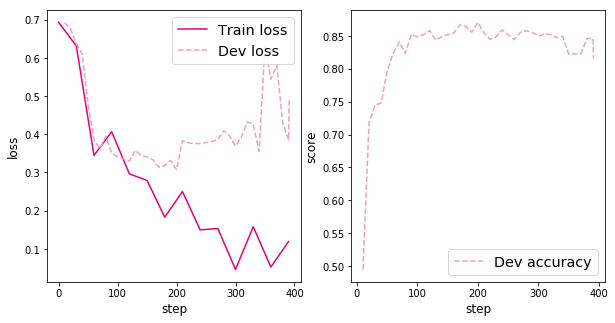

In [13]:
import matplotlib.pyplot as plt
from nndl import plot

plot(runner, 'att-loss-acc.pdf')

### 8.1.3.2 模型评价
模型评价加载最好的模型，然后在测试集合上进行评价。

In [14]:
model_path = "checkpoint/model_best.pdparams"
runner.load_model(model_path)
accuracy, _ =  runner.evaluate(test_loader)
print(f"Evaluate on test set, Accuracy: {accuracy:.5f}")

Evaluate on test set, Accuracy: 0.86480


## 8.1.4 使用点积注意力模型进行实验

对于点积注意力模型，实现方法类似，只需要在双向LSTM的后面加入点积注意力模型，点积注意力模型的输入是双向LSTM的每个时刻的输出，最后接入分类层即可。

### 8.1.4.1 模型训练

模型训练使用RunnerV3，并使用交叉熵损失函数，并用Adam作为优化器训练Model\_LSTMAttention网络，其中Model\_LSTMAttention模型传入了点积注意力模型。然后训练集上训练2个回合，并保存准确率最高的模型作为最佳模型，Model\_LSTMAttention模型除了使用点积模型外，其他的参数配置完全跟加性模型保持一致。代码实现如下：

In [15]:
paddle.seed(2021)
# 实例化基于LSTM的点积注意力模型
model_atten = Model_LSTMAttention(
    hidden_size,
    embedding_size,
    vocab_size,
    n_classes=n_classes,
    n_layers=n_layers,
    use_additive=False,
)
# 定义优化器
optimizer = Adam(parameters=model_atten.parameters(), learning_rate=learning_rate)
# 实例化RunnerV3
runner = RunnerV3(model_atten, optimizer, criterion, metric)
save_path = "./checkpoint/model_best.pdparams"

start_time = time.time()
# 训练
runner.train(
    train_loader,
    dev_loader,
    num_epochs=epochs,
    log_steps=10,
    eval_steps=10,
    save_path=save_path,
)
end_time = time.time()
print("训练时间:{}".format(end_time-start_time))

[Train] epoch: 0/2, step: 0/392, loss: 0.69304
[Train] epoch: 0/2, step: 10/392, loss: 0.68804
[Evaluate]  dev score: 0.49472, dev loss: 0.69163
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.49472
[Train] epoch: 0/2, step: 20/392, loss: 0.67802
[Evaluate]  dev score: 0.56160, dev loss: 0.67951
[Evaluate] best accuracy performence has been updated: 0.49472 --> 0.56160
[Train] epoch: 0/2, step: 30/392, loss: 0.64008
[Evaluate]  dev score: 0.74208, dev loss: 0.64587
[Evaluate] best accuracy performence has been updated: 0.56160 --> 0.74208
[Train] epoch: 0/2, step: 40/392, loss: 0.48982
[Evaluate]  dev score: 0.77176, dev loss: 0.48411
[Evaluate] best accuracy performence has been updated: 0.74208 --> 0.77176
[Train] epoch: 0/2, step: 50/392, loss: 0.43586
[Evaluate]  dev score: 0.81136, dev loss: 0.42632
[Evaluate] best accuracy performence has been updated: 0.77176 --> 0.81136
[Train] epoch: 0/2, step: 60/392, loss: 0.36778
[Evaluate]  dev score: 0.82968, dev loss

```
训练时间:148.5727310180664
```

可视化观察训练集与验证集的损失及准确率变化情况。代码实现如下：

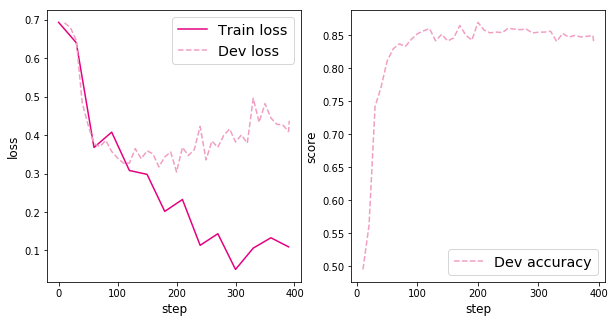

In [16]:
plot(runner, 'dotproduct-loss-acc.pdf')

### 8.1.4.2 模型评价

模型评价加载最好的模型，然后在测试集合上进行评价。代码实现如下：

In [17]:
model_path = "checkpoint/model_best.pdparams"
runner.load_model(model_path)
accuracy, _ =  runner.evaluate(test_loader)
print(f"Evaluate on test set, Accuracy: {accuracy:.5f}")

Evaluate on test set, Accuracy: 0.86936


从上面的实验可以看出：

（1）在不加注意力机制的情况下，测试集上的准确率为0.86064，加入了加性注意力后，测试集的准确率为0.86488；换成点积注意力后，测试集上的准确率为0.86936。
相比于不加注意力机制的模型，加入注意力机制的模型效果会更好些。

（2）另外，从加性注意力和点积注意力的结果可以看出，点积注意力的准确率更好些。

### 8.1.4.3 注意力可视化

为了验证注意力机制学到了什么，我们把加性注意力的权重提取出来，然后进行可视化分析。代码实现如下：

In [18]:
model_path = "checkpoint/model_best.pdparams"
model_atten = Model_LSTMAttention(
    hidden_size,
    embedding_size,
    vocab_size,
    n_classes=n_classes,
    n_layers=n_layers,
    use_additive=False,
)
# runner.load_model(model_path)
model_state_dict = paddle.load(model_path)
model_atten.set_state_dict(model_state_dict)

In [19]:
text = "this great science fiction film is really awesome"
# text = "This movie was craptacular"
# text = "I got stuck in traffic on the way to the theater"
# 分词
sentence = text.split(" ")
# 词映射成ID的形式
tokens = [
    word2id_dict[word] if word in word2id_dict else word2id_dict["[oov]"]
    for word in sentence
]
# 取前max_seq_len的单词
tokens = tokens[:max_seq_len]
# 序列长度
seq_len = paddle.to_tensor([len(tokens)])
# 转换成Paddle的Tensor
input_ids = paddle.to_tensor(tokens, dtype="int64").unsqueeze(0)
inputs = [input_ids, seq_len]
# 模型开启评估模式
model_atten.eval()
# 设置不求梯度
with paddle.no_grad():
    # 预测输出
    pred_prob = model_atten(inputs)
# 提取注意力权重
atten_weights = model_atten.attention.attention_weights
print("输入的文本为：{}".format(text))
print("转换成id的形式为：{}".format(input_ids.numpy()))
print("训练的注意力权重为：{}".format(atten_weights.numpy()))

输入的文本为：this great science fiction film is really awesome
转换成id的形式为：[[  10   88 1196 1839   24    7   61 1635]]
训练的注意力权重为：[[0.09350643 0.25606698 0.08582163 0.11344668 0.09067672 0.09059495
  0.09276529 0.17712136]]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:101: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  ret = np.asscalar(ex)


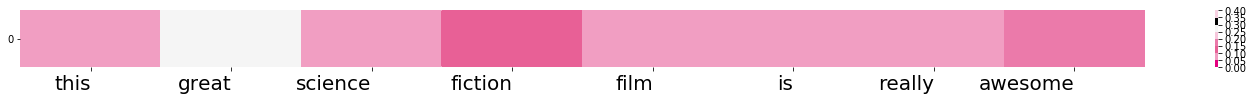

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
# 对文本进行分词，得到过滤后的词
list_words = text.split(" ")
# 提取注意力权重，转换成list
data_attention = atten_weights.numpy().tolist()
# 取出前max_seq_len变换进行特征融合，得到最后个词
list_words = list_words[:max_seq_len]
# 把权重转换为DataFrame，列名为单词
d = pd.DataFrame(data=data_attention, columns=list_words)
f, ax = plt.subplots(figsize=(20, 1.5))
# 用heatmap可视化
# sns.heatmap(d, vmin=0, vmax=0.4, ax=ax)
# sns.heatmap(d, vmin=0, vmax=0.4, ax=ax, cmap="OrRd")

my_colors=['#e4007f', '#f19ec2', '#e86096', '#eb7aaa', '#f6c8dc', '#f5f5f5', '#000000', '#f7d2e2']
sns.heatmap(d, vmin=0, vmax=0.4, ax=ax, cmap=my_colors)
# 纵轴旋转360度
label_y = ax.get_yticklabels()
plt.setp(label_y, rotation=360, horizontalalignment="right")
# 横轴旋转0度
label_x = ax.get_xticklabels()
plt.setp(label_x, rotation=0, horizontalalignment="right", fontsize=20)
plt.savefig('att-vis.pdf')
plt.show()

输出结果如图所示，颜色越深代表权重越高，从图可以看出，注意力权重比较高的单词是"great"，"awesome"。

********
实现《神经网络与深度学习》第8.2节中定义的其它注意力打分函数，并重复上面的实验。
********

# 8.2 . 基于双向LSTM和多头自注意力的文本分类实验

在上一节介绍的注意力机制中需要一个外部的查询向量$\mathbf q$，用来选择和任务相关的信息，并对输入的序列表示进行聚合。
在本节中，我们进一步实现更强大的自注意力模型，同样和双向LSTM网络一起来实现上一节中的文本分类任务。

## 8.2.1 自注意力模型

当使用神经网络来处理一个变长的向量序列时，我们通常可以使用卷积网络或循环网络进行编码来得到一个相同长度的输出向量序列。基于卷积或循环网络的序列编码都是一种局部的编码方式，只建模了输入信息的局部依赖关系。虽然循环网络理论上可以建立长距离依赖关系，但是由于信息传递的容量以及梯度消失问题，实际上也只能建立短距离依赖关系。


**自注意力** {Self-Attention}是可以有效的直接解决长程依赖问题的方法，相当于构建一个以输入序列中的每个元素为单元的全连接网络（即每个全连接网络的每个节点为一个向量），利用注意力机制来“动态”地生成全连接网络的权重。

下面，我们按照从简单到复杂的步骤分别介绍简单自注意力、QKV自注意力、多头自注意力。


### 8.2.1.1 最简单的自注意力

我们先来看最简单的自注意力模型。

假设一个输入序列$\mathbf X\in \mathbb{R}^{L\times D}$，为了建模序列中所有元素的交互关系，我们将可以将输入序列中每个元素$\mathbf x_m$作为查询向量，利用注意力机制从整个序列中选取和自己相关的信息，就得到了该元素的上下文表示$\mathbf h_m\in \mathbb{R}^{1\times D}$。
$$
\mathbf h_{m} = \sum_{n=1}^{L} \alpha_{mn} \mathbf x_n =softmax(\mathbf x_m \mathbf X^T) \mathbf X,
$$
其中$\alpha_{mn}$表示第$m$个元素对第$n$个元素的注意力权重，注意力打分函数使用点积函数。

输入一个文本序列The movie is nice进行，如果计算单词movie的上下文表示，可以将movie作为查询向量，计算和文本序列中所有词的注意力分布，并根据注意力分布对所有词进行加权平均，得到movie的上下文表示。和卷积网络或循环网络相比，这种基于注意力方式会融合更远的上下文信息。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/bd809b713ff14dae8c30f08279865004a28045a292b845fd8178cca6ae2922e2" width="800px"></center>
<br><center>图8.7 自注意力示例</center></br>


对于输入序列$\mathbf X\in \mathbb{R}^{L\times D}$，自注意力可以表示为
$$
\mathbf Z = softmax(\mathbf X \mathbf X^T) \mathbf X,
$$
其中$softmax()$是按行进行归一化，Z表示的是注意力分布的输出。计算方式如下图所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/5add2e1686d0436a8be1e79270442daa27c807661b0a4695a4bd6d81023111e9" width="400px"></center>
<br><center>图8.8 整个序列的自注意力示例</center></br>



********
动手实现上面的简单注意力模型，并加入到第8.1节中构建模型的LSTM层和注意力层之间，观察是否可以改进实验效果。
********

### 8.2.1.2 QKV自注意力

上面介绍的简单自注意力模型只是应用了注意力机制来使用序列中的元素可以长距离交互，模型本身不带参数，因此能力有限。

为了提高模型能力，自注意力模型经常采用**查询-键-值**{Query-Key-Value，QKV}模式。

将输入序列$\mathbf X\in \mathbb{R}^{B\times L\times D}$经过线性变换分别映射到查询张量、键张量、值张量。

$$
\qquad \mathbf Q=\mathbf X\mathbf W^{Q} \in \mathbb{R}^{B\times L \times D},\\
\qquad \mathbf K=\mathbf X\mathbf W^{K} \in \mathbb{R}^{B\times L \times D},\\
\qquad  \mathbf V=\mathbf X\mathbf W^{V} \in \mathbb{R}^{B\times L \times D},
$$
其中$\mathbf W^{Q} \in \mathbb{R}^{D \times D}$,$\mathbf W^{K} \in \mathbb{R}^{D \times D}$,$\mathbf W^{V} \in \mathbb{R}^{D \times D}$是可学习的映射矩阵。为简单起见，这里令映射后$\mathbf Q,\mathbf K,\mathbf V$的特征维度相同，都为$D$。

QKV自注意力的公式表示如下：
$$
\mathrm{attention}(\mathbf Q,\mathbf K,\mathbf V) =  softmax(\frac{\mathbf Q\mathbf K^T}{\sqrt{D}}) \mathbf V
$$
其中$softmax(\cdot)$是按行进行归一化。计算方式如下图所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/7008c957a13a406a9673397afb10b23cc3000efbe49e498f844b0bead85483c9" width="400px"></center>
<br><center>图8.9 整个序列的自注意力示例</center></br>

QKV注意力中，假设$\mathbf Q$和$\mathbf K$都是独立的随机向量，都满足0均值和为1的单位方差，那么$\mathbf Q$和$\mathbf K$点积以后的均值为0，方差变成了$D$，当输入向量的维度$D$比较高的时候，QKV注意力往往有较大的方差，从而导致Softmax的梯度比较小，不利于模型的收敛，因此QKV注意力除以了一个$\sqrt{D}$有效降低方差，加速模型收敛。

**屏蔽序列中的[PAD]**

在QKV注意力的实现中，需要注意的如何屏蔽[PAD]元素不参与注意力的计算。

带掩码的QKV注意力实现原理示意如下图所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/9f96ef66626749a1b8afb9f44d209effa10daabfa3c04ac9affe75cf7be53d5d" width="800px"></center>
<br><center>图8.10 QKV注意力中屏蔽[PAD]位置的实现过程示意</center></br>


具体实现步骤如下：

（1）根据序列的长度创建一个掩码张量$\mathbf M\in \{0,1\}^{B\times L \times L}$，每个序列都有一个真实的长度，对于每个序列中小于真实长度的位置设置为True，对于大于等于真实长度的位置，说明是填充[PAD]，则设置为False。
```
# arrange: [1,seq_len],比如seq_len=4, arrange变为 [0,1,2,3]
arrange = paddle.arange((seq_len), dtype=paddle.float32).unsqueeze(0)
# valid_lens : [batch_size*seq_len,1]
valid_lens = valid_lens.unsqueeze(1)
# mask [batch_size*seq_len, seq_len]
mask = arrange < valid_lens
```


（2）根据布尔矩阵mask中False的位置，将注意力打分序列中对应的位置填充为-inf(实际实现过程中可设置一个非常小的数，例如-1e9)。

```
# 给mask为False的区域填充-1e9
# y: [batch_size, seq_len, seq_len]
y = paddle.full(score.shape, -1e9, score.dtype)
# score: [batch_size, seq_len,seq_len]
score = paddle.where(mask, score, y)
```

QKV自注意力的代码实现如下

In [ ]:
import paddle.nn.functional as F
import paddle.nn as nn
import paddle

class QKVAttention(nn.Layer):
    def __init__(self, size):
        super(QKVAttention, self).__init__()
        size = paddle.to_tensor([size], dtype="float32")
        self.sqrt_size = paddle.sqrt(size)

    def forward(self, Q, K, V, valid_lens) :
        """
        输入：
            - Q：查询向量，shape = [batch_size, seq_len, hidden_size]
            - K：键向量，shape = [batch_size, seq_len, hidden_size]
            - V：值向量，shape = [batch_size, seq_len, hidden_size]
            - valid_lens：序列长度，shape =[batch_size]
        输出：
            - context ：输出矩阵，表示的是注意力的加权平均的结果
        """
        batch_size, seq_len, hidden_size = Q.shape
        # score: [batch_size, seq_len, seq_len]
        score = paddle.matmul(Q, K.transpose((0, 2, 1))) / self.sqrt_size
        # arrange: [1,seq_len],比如seq_len=2, arrange变为 [0, 1]
        arrange = paddle.arange((seq_len), dtype=paddle.float32).unsqueeze(0)
        # valid_lens : [batch_size*seq_len, 1]
        valid_lens = valid_lens.unsqueeze(1)
        # mask [batch_size*seq_len, seq_len]
        mask = arrange < valid_lens
        # mask : [batch_size, seq_len, seq_len]
        mask = paddle.reshape(mask, [batch_size, seq_len, seq_len])
        # 给mask为False的区域填充-1e9
        # y: [batch_size, seq_len, seq_len]
        y = paddle.full(score.shape, -1e9, score.dtype)
        # score: [batch_size, seq_len,seq_len]
        score = paddle.where(mask, score, y)
        # attention_weights: [batch_size, seq_len, seq_len]
        attention_weights = F.softmax(score, -1)
        self._attention_weights = attention_weights
        # 加权平均
        # context: [batch_size, seq_len, hidden_size]
        context = paddle.matmul(attention_weights, V)
        return context

    @property
    def attention_weights(self):
        return self._attention_weights

paddle.seed(2022)
Q = paddle.rand(shape=[2, 2, 3])
K = paddle.rand(shape=[2, 2, 3])
V = paddle.rand(shape=[2, 2, 3])
valid_lens = paddle.to_tensor([1, 1, 2, 2])
print("查询向量为 {}".format(Q.numpy()))
print("键向量为 {}".format(K.numpy()))
print("值向量为 {}".format(V.numpy()))
qkv_atten = QKVAttention(3)
context = qkv_atten(Q, K, V, valid_lens)
print("注意力的输出为 : {}".format(context.numpy()))
print("注意力权重为 : {}".format(qkv_atten.attention_weights.numpy()))

从输出可以看出，QKV注意力的输入是$\mathbf Q$，$\mathbf K$，$\mathbf V$，然后计算缩放点积注意力得到最终的输出。

### 8.2.1.3 多头自注意力

为了进一步提升自注意力的能力，我们将QKV注意力扩展为**多头**{Multi-Head}模式，其思想和多通道卷积非常类似，利用多组QKV自注意力来提升模型能力。

**多头自注意力**{Multi-Head Self-Attention，MHSA}首先会分别进行多组的QKV注意力的计算，其中每组称为一个**头**{head}。每单个头可以看作是序列中所有元素的一次特征融合。之后，把得到的多个头拼接到一起，通过线性变换进行特征融合，得到最后的输出表示。多头自注意力的结构如图8.11所示，分为三个部分：线性变换、单头QKV注意力和多头融合。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/96d9403101e94dd9b2691fc9f91c5c331364b9a31ffc42cf8cb7aa81154dbc8e" width="800px"></center>
<br><center>图8.11 多头注意力结构图</center></br>



假设输入序列为$\mathbf X\in \mathbb{R}^{B\times L\times D}$，其中$B$为批量大小，$L$为序列长度，$D$为特征维度，通过以下三个步骤来实现多头自注意力。

（1）**线性变换**：分别计算每个单头的QKV张量。在计算第$m$个头时，将$\mathbf X$做三个线性变换分别映射到分别查询张量、键张量和值张量：
$$
\qquad \mathbf Q_m=\mathbf X\mathbf W_{m}^{Q}\\
\qquad \mathbf K_m=\mathbf X\mathbf W_{m}^{K}\\
\qquad  \mathbf V_m=\mathbf X\mathbf W_{m}^{V}
$$
其中$\mathbf W_{m}^{\mathbf Q} \in \mathbb{R}^{D \times D_m}$,$\mathbf W_{m}^{K} \in \mathbb{R}^{D \times D_m}$,$\mathbf W_{m}^{\mathbf V} \in \mathbb{R}^{D \times D_m}$，$D_m$是映射后QKV的特征维度。

（2）**单头QKV自注意力**：分别计算每个单头的QKV自注意力。通过QKV自注意力计算第$m$个头$head_{m}$：
$$
head_{m}= \mathrm{attention}(\mathbf Q_m,\mathbf K_m,\mathbf V_m) \in \mathbb{R}^{B\times L\times D_m},
$$
其中$\mathrm{attention}(\cdot)$为公式QKV自注意力中的函数。

（3）**多头融合**：将多个头进行特征融合：
$$
\mathbf Z=\mathrm{MultiHeadSelfAttention}(\mathbf X)
\triangleq
\bigoplus(head_{1},head_{2},...,head_{M})\mathbf W'
$$
其中$\oplus$表示对张量的最后一维进行向量拼接，$\mathbf W' \in \mathbb{R}^{(MD_m) \times D'}$是可学习的参数矩阵，$D'$表示的输出特征的维度。

这里为了简单起见，令每个头的特征维度$D_m=\frac{D}{M}$，输出特征维度$D'=D$和输入维度相同。

**动手实现**

下面动手实现多头自注意力。为了能够使多个头的QKV自注意力可以并行计算，需要对QKV的张量进行重组，其实现原理如图8.12所示。


<center><img src="https://ai-studio-static-online.cdn.bcebos.com/76e448f3ce6f4fe88380b285436c8c34bca9dc36131842d582fa09f6caba1ea0" width="800px"></center>
<br><center>图8.12 多头自注意力实现原理图</center></br>


具体实现步骤如下：

（1）**线性变换**：将输入序列$\mathbf X\in \mathbb{R}^{B\times L\times D}$做线性变换，得到$\mathbf Q,\mathbf K,\mathbf V \in \mathbb{R}^{B\times L\times D}$三个张量。这里使用`nn.Linear`算子来实现线性变换，并且得到的$\mathbf Q,\mathbf K,\mathbf V$张量是一次性计算多个头的。

```
# 查询
Q_proj = nn.Linear(qsize, inputs_size, bias_attr=False)
# 键
K_proj = nn.Linear(ksize, inputs_size, bias_attr=False)
# 值
V_proj = nn.Linear(vsize, inputs_size, bias_attr=False)
batch_size, seq_len, hidden_size = X.shape
# Q,K,V: [batch_size,seq_len,hidden_size]
Q, K, V = Q_proj(X), K_proj(X), V_proj(X)
```

（2）**多头分组**：上一步中得到的$\mathbf Q,\mathbf K,\mathbf V \in \mathbb{R}^{B\times L\times D}$张量是一次性计算多个头的，需要对$\mathbf Q,\mathbf K,\mathbf V$张量的特征维度进行分组，分为$M$组，每组为一个头。
$$
(B\times L\times D) \xRightarrow {\text{reshape}} (B\times L\times M \times D_m),
$$
其中$M$是头数量，$D_m$是每个头的特征维度，并有$D=M\times D_m$。

（3）**形状重组**：在上一步分组后，得到$\mathbf Q,\mathbf K,\mathbf V \in \mathbb{R}^{B\times L\times M\times D_m}$。由于不同注意力头在计算QKV自注意力是独立的，因此把它们看做是不同的样本，并且把多头的维度$M$合并到样本数量维度$B$，便于计算QKV自注意力。
$$
(B \times L \times M \times D_m) \xRightarrow{\text{transpose}} (B \times M \times L \times D_m) \xRightarrow{\text{reshape}} (BM \times L \times D_m)

$$
对每个$\mathbf Q,\mathbf K,\mathbf V$都执行上面的操作，得到$\mathbf Q,\mathbf K,\mathbf V \in \mathbb{R}^{((B M) \times L \times D_m)}$。

经过形状重组后，$B$个样本的多头自注意力转换为$B*M$个样本的单头QKV自注意力。
这里实现了`split_head_reshape`函数来执行上面第（2）、（3）步的操作。

In [ ]:
def split_head_reshape(X, heads_num, head_size):
    """
    输入：
        - X：输入矩阵，shape=[batch_size, seq_len, hidden_size]
    输出：
        - output：输出多头的矩阵，shape= [batch_size * heads_num, seq_len, head_size]
    """
    batch_size, seq_len, hidden_size = X.shape
    # X: [batch_size, seq_len, heads_num, head_size]
    # 多头分组
    X = paddle.reshape(x=X, shape=[batch_size, seq_len, heads_num, head_size])
    # X: [batch_size, heads_num, seq_len, head_size]
    # 形状重组
    X = paddle.transpose(x=X, perm=[0, 2, 1, 3])
    # X: [batch_size*heads_num, seq_len, head_size]
    X = paddle.reshape(X, [batch_size * heads_num, seq_len, head_size])
    return X

（4）**QKV注意力**：对最新的$\mathbf  Q,\mathbf  K,\mathbf  V \in \mathbb{R}^{(BM)\times L \times D_m)}$，计算QKV注意力：
$$
\mathbf  H= \mathrm{attention}(\mathbf  Q,\mathbf  K,\mathbf  V) \in \mathbb{R}^{(BM)\times L \times D_m},
$$
其中$\mathrm{attention}()$为公式QKV注意力中的函数。

```
attention = QKVAttention(head_size)
# out: [batch_size*heads_num, seq_len, head_size]
out = attention(Q, K, V, valid_lens)
```

（5）**重组恢复**：将形状重组恢复到原来的形状

$$
(B M \times L \times D_m) \xRightarrow{\text{reshape}} (B \times M \times L \times D_m) \xRightarrow{\text{transpose}}(B \times L \times M \times D_m)
$$

```
# out: [batch_size, heads_num, seq_len, head_size]
out = paddle.reshape(out, [batch_size, heads_num, seq_len, head_size])
# out: [batch_size, seq_len, heads_num, head_size]
out = paddle.transpose(out, perm=[0, 2, 1, 3])
```

（6）**多头融合**：根据公式\eqref{eq:att-mhsa-output-linear}将多个头进行特征融合。首先将多头的特征合并，还原为原来的维度。

$$
(B\times L\times M \times D_m) \xRightarrow{\text{reshape}}(B\times L\times D),
$$

然后再进行特征的线性变换得到最后的输出。这里线性变换也使用\code{nn.Linear}实现。

```
# 输出映射
out_proj = nn.Linear(inputs_size, inputs_size, bias_attr=False)

# 多头注意力输出拼接
# out: [batch_size, seq_len, heads_num * head_size]
out = paddle.reshape(x=out, shape=[0, 0, out.shape[2] * out.shape[3]])
# 输出映射
out = self.out_proj(out)
```

**多头自注意力算子**

多头自注意力算子`MultiHeadSelfAttention`的详细代码实现如下：

In [ ]:
import paddle.nn as nn
import paddle

class MultiHeadSelfAttention(nn.Layer):
    def __init__(self, inputs_size, heads_num, dropout=0.0):
        super(MultiHeadSelfAttention, self).__init__()
        # 输入的embedding维度
        self.inputs_size = inputs_size
        self.qsize, self.ksize, self.vsize = inputs_size, inputs_size, inputs_size
        # head的数目
        self.heads_num = heads_num
        # 每个head的输入向量的维度
        self.head_size = inputs_size // heads_num
        # 输入的维度inputs_size需要整除head数目heads_num
        assert (
            self.head_size * heads_num == self.inputs_size
        ), "embed_size must be divisible by heads_num"
        # 查询
        self.Q_proj = nn.Linear(self.qsize, inputs_size, bias_attr=False)
        # 键
        self.K_proj = nn.Linear(self.ksize, inputs_size, bias_attr=False)
        # 值
        self.V_proj = nn.Linear(self.vsize, inputs_size, bias_attr=False)
        # 输出映射
        self.out_proj = nn.Linear(inputs_size, inputs_size, bias_attr=False)
        # QKV注意力
        self.attention = QKVAttention(self.head_size)

    def forward(self, X, valid_lens):
        """
        输入：
            - X：输入矩阵，shape=[batch_size,seq_len,hidden_size]
            - valid_lens： 长度矩阵，shape=[batch_size]
        输出：
            - output：输出矩阵，表示的是多头注意力的结果
        """
        self.batch_size, self.seq_len, self.hidden_size = X.shape
        # Q,K,V: [batch_size, seq_len, hidden_size]
        Q, K, V = self.Q_proj(X), self.K_proj(X), self.V_proj(X)
        # Q,K,V: [batch_size*heads_num, seq_len, head_size]
        Q, K, V = [
            split_head_reshape(item, self.heads_num, self.head_size)
            for item in [Q, K, V]
        ]
        # 把valid_lens复制 heads_num * seq_len次
        # 比如valid_lens_np=[1,2],num_head*seq_len=2 则变为 [1,1,2,2]
        valid_lens = paddle.repeat_interleave(
                valid_lens, repeats=self.heads_num * self.seq_len, axis=0)
        # out: [batch_size*heads_num, seq_len, head_size]
        out = self.attention(Q, K, V, valid_lens)
        # out: [batch_size, heads_num, seq_len, head_size]
        out = paddle.reshape(
            out, [self.batch_size, self.heads_num, self.seq_len, self.head_size]
        )
        # out: [batch_size, seq_len, heads_num, head_size]
        out = paddle.transpose(out, perm=[0, 2, 1, 3])
        # 多头注意力输出拼接
        # out: [batch_size, seq_len, heads_num * head_size]
        out = paddle.reshape(x=out, shape=[0, 0, out.shape[2] * out.shape[3]])
        # 输出映射
        out = self.out_proj(out)
        return out

对上面的实现进行验证，输入以形状为$2\times 2 \times 4$的张量，表示两个2序列，每个序列有2个单词，每个单词的长度是4维。

In [ ]:
paddle.seed(2021)
X = paddle.rand((2, 2, 4))
valid_lens= paddle.to_tensor([1,2])
print('输入向量 {}'.format(X.numpy()))
multi_head_attn = MultiHeadSelfAttention(heads_num=2,inputs_size=4)
context = multi_head_attn(X,valid_lens)  
print('注意力的输出为 : {}'.format(context.numpy()))
print('注意力权重为 : {}'.format(multi_head_attn.attention.attention_weights.numpy()))

多头自注意力把输入矩阵分成了2个头，分别计算QKV 注意力，计算结束后把2个头的结果拼接在一起输出。权重的输出为0的地方表示被掩码去除，不参与注意力的计算，所以输出为0.

## 8.2.2 基于LSTM和多头自注意力的文本分类的模型构建

基于LSTM和多头自注意力的文本分类模型的模型结构如下图所示，整个模型由以下几个部分组成：

1） 嵌入层：将输入句子中的词语转换为向量表示；

2） LSTM层：基于双向LSTM网络来建模句子中词语的上下文表示；

3） 自注意力层：使用多头自注意力机制来计算LSTM的自注意力特征表示；

4） 汇聚层：对多头自注意力的输出进行平均汇聚得到整个句子的表示；

5） 线性层：输出层，预测对应的类别得分.



<center><img src="https://ai-studio-static-online.cdn.bcebos.com/bb328336d6cf43d898eb09ee9f38315180908bffad0a4ba28f6dd7cdb5ada099" width="800px"></center>
<br><center>基于双向LSTM和多头自注意力的文本分类模型</center></br>

本节中，我们直接复用第6.4节中实现的嵌入层和双向LSTM层，使用上一小节中定义的多头自注意力算子`MultiHeadSelfAttention`，以及第8.1.2.5节模型的线性层。


### 8.2.2.1 模型汇总

基于双向LSTM和多头注意力机制的网络就是在原有的双向LSTM的基础上实现了多头自注意力，求平均后接入分类层输出，代码实现如下

In [ ]:
class AveragePooling(nn.Layer):
    def __init__(self):
        super(AveragePooling, self).__init__()
    
    def forward(self, sequence_output, sequence_length):
        sequence_length = paddle.cast(sequence_length.unsqueeze(-1), dtype="float32")
        # 根据sequence_length生成mask矩阵，用于对Padding位置的信息进行mask
        max_len = sequence_output.shape[1]
        mask = paddle.arange(max_len) < sequence_length
        mask = paddle.cast(mask, dtype="float32").unsqueeze(-1)
        # 对序列中paddling部分进行mask
        sequence_output = paddle.multiply(sequence_output, mask)
        # 对序列中的向量取均值
        batch_mean_hidden = paddle.divide(paddle.sum(sequence_output, axis=1), sequence_length)
        return batch_mean_hidden

In [ ]:
class Model_LSTMSelftAttention(nn.Layer):
    def __init__(
        self,
        hidden_size,
        embedding_size,
        vocab_size,
        n_classes=10,
        n_layers=1,
        attention=None,
    ):
        super(Model_LSTMSelftAttention, self).__init__()
        # 表示LSTM单元的隐藏神经元数量，它也将用来表示hidden和cell向量状态的维度
        self.hidden_size = hidden_size
        # 表示词向量的维度
        self.embedding_size = embedding_size
        # 表示词典的的单词数量
        self.vocab_size = vocab_size
        # 表示文本分类的类别数量
        self.n_classes = n_classes
        # 表示LSTM的层数
        self.n_layers = n_layers
        # 定义embedding层
        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size, embedding_dim=self.embedding_size
        )
        # 定义LSTM，它将用来编码网络
        self.lstm = nn.LSTM(
            input_size=self.embedding_size,
            hidden_size=self.hidden_size,
            num_layers=self.n_layers,
            direction="bidirectional",
        )
        self.attention = attention
        # 实例化聚合层，聚合层与循环网络章节使用一致
        self.average_layer = AveragePooling()
        # 定义分类层，用于将语义向量映射到相应的类别
        self.cls_fc = nn.Linear(
            in_features=self.hidden_size * 2, out_features=self.n_classes
        )

    def forward(self, inputs):
        input_ids, valid_lens = inputs
        # 获取词向量
        embedded_input = self.embedding(input_ids)
        # 使用LSTM进行语义编码
        last_layers_hiddens, (last_step_hiddens, last_step_cells) = self.lstm(
            embedded_input, sequence_length=valid_lens
        )
        # 计算多头自注意力
        last_layers_hiddens = self.attention(last_layers_hiddens, valid_lens)
        # 使用聚合层聚合sequence_output
        last_layers_hiddens = self.average_layer(last_layers_hiddens, valid_lens)
        # 将其通过分类线性层，获得初步的类别数值
        logits = self.cls_fc(last_layers_hiddens)
        return logits

## 8.2.3 模型训练

实例化组装RunnerV3的重要组件：模型、优化器、损失函数和评价指标，其中模型部分传入的是多头自注意力，然后便可以开始进行模型训练。损失函数使用的是交叉熵损失，评价函数使用的是Accuracy，跟上一节的设置保持一致。

In [ ]:
from paddle.optimizer import Adam
from nndl import Accuracy, RunnerV3

paddle.seed(2021)
# 迭代的epoch数
epochs = 2
# 词汇表的大小
vocab_size = len(word2id_dict)
# lstm的输出单元的大小
hidden_size = 128
# embedding的维度
embedding_size = 128
# 类别数
n_classes = 2
# lstm的层数
n_layers = 1
# 学习率
learning_rate = 0.001
# 指定评价指标
metric = Accuracy()
# 交叉熵损失
criterion = nn.CrossEntropyLoss()
# 指定评价指标
metric = Accuracy()
multi_head_attn = MultiHeadSelfAttention(inputs_size=256, heads_num=8)
# 框架API的复现
# multi_head_attn = nn.MultiHeadAttention(embed_dim=256, num_heads=8, bias_attr=False)
# 实例化基于LSTM的注意力模型
model_atten = Model_LSTMSelftAttention(
    hidden_size,
    embedding_size,
    vocab_size,
    n_classes=n_classes,
    n_layers=n_layers,
    attention=multi_head_attn,
)
# 定义优化器
optimizer = Adam(parameters=model_atten.parameters(), learning_rate=learning_rate)
# 实例化RunnerV3
runner = RunnerV3(model_atten, optimizer, criterion, metric)
save_path = "./checkpoint/model_best.pdparams"
# 训练
runner.train(
    train_loader,
    dev_loader,
    num_epochs=epochs,
    log_steps=10,
    eval_steps=10,
    save_path=save_path,
)

可视化观察训练集与验证集的损失变化情况。

In [ ]:
from nndl import plot

plot(runner, 'att-loss-acc2.pdf')

## 8.2.4 模型评价

In [ ]:
model_path = "checkpoint/model_best.pdparams"
runner.load_model(model_path)
accuracy, _ =  runner.evaluate(test_loader)
print(f"Evaluate on test set, Accuracy: {accuracy:.5f}")

1）在不加注意力机制的情况下，测试集上的准确率为0.86064。
加入了多头注意力后，准确率变为了0.86552。说明多头注意力能够起到信息筛选和聚合的作用。

2）和第8.1节的点积注意力和加性注意力相比，多头自注意力的准确率介于加性注意力和点积注意力之间，因此同等条件下，多头自注意力模型的效果要优于普通的加性注意力模型，最终点积注意力的准确率最高。

********
前面上一节的注意力机制相比，多头自注意力模型引入了更多的参数，因此模型会更复杂，通常需要更多的训练数据才能达到比较好的性能。请思考可以从哪些角度来提升自注意力模型的性能？
********


任取一条英文文本数据，然后使用模型进行预测，代码如下：

In [ ]:
text = "this movie is so great. I watched it three times already"
# 句子按照空格分开
sentence = text.split(" ")
# 单词转ID
tokens = [
    word2id_dict[word] if word in word2id_dict else word2id_dict["[oov]"]
    for word in sentence
]
# 取max_seq_len
tokens = tokens[:max_seq_len]
# 长度
seq_len = paddle.to_tensor([len(tokens)])
# 转换成Tensor
input_ids = paddle.to_tensor([tokens], dtype="int64")
inputs = [input_ids, seq_len]
# 预测
logits = runner.predict(inputs)
# label词表
id2label = {0: "消极情绪", 1: "积极情绪"}
# 取最大值的索引
label_id = paddle.argmax(logits, axis=1).numpy()[0]
# 根据索引取出输出
pred_label = id2label[label_id]
print("Label: ", pred_label)

从输出结果看，这句话的预测结果是积极情绪，这句话本身的情感是正向的，说明预测结果正确。

********
尝试将LSTM层去掉，只是用注意力层重复上面实验，观察结果并分析原因。
********